In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, col, udf, lit
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


spark = SparkSession.builder \
    .appName("ProductDataProcessing") \
    .getOrCreate()

file_path = "dataset.csv"
df = spark.read.option("header", "true").csv(file_path, inferSchema=True)

df.show(5)


24/12/03 10:26:21 WARN Utils: Your hostname, Zaki-69 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/12/03 10:26:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/12/03 10:26:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/12/03 10:26:36 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+---------------------------------+
|ProductID|ProductName|   Category| Price|Rating|NumReviews|StockQuantity|Discount|Sales| DateAdded|       City|Stock In Vast or Limited Quantity|
+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+---------------------------------+
|        1| Headphones|Electronics|400.31|   1.7|      3772|           20|    0.08|  466|2023-11-10|Albuquerque|                             NULL|
|        2| Headphones|Electronics|235.03|   2.3|      2919|          663|    0.33| 1332|2023-09-28|     Queens|                             NULL|
|        3| Smartwatch|Electronics| 417.9|   1.8|      1184|          459|    0.31|  252|2023-10-20|     Austin|                             NULL|
|        4| Smartphone|Electronics| 152.7|   3.4|      2047|          475|    0.49| 1806|2023-12-05|     Dallas|      

# Validasi Data Type

In [2]:
df_cleaned = df

df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

df_cleaned = df_cleaned.withColumn("Price", col("Price").cast("float")) \
    .withColumn("Rating", col("Rating").cast("float")) \
    .withColumn("NumReviews", col("NumReviews").cast("int")) \
    .withColumn("StockQuantity", col("StockQuantity").cast("int")) \
    .withColumn("Discount", col("Discount").cast("float")) \
    .withColumn("Sales", col("Sales").cast("int")) \
    .withColumn("DateAdded", col("DateAdded").cast("date"))

df_cleaned.printSchema()
df_cleaned.show(5)

+---------+-----------+--------+-----+------+----------+-------------+--------+-----+---------+----+---------------------------------+
|ProductID|ProductName|Category|Price|Rating|NumReviews|StockQuantity|Discount|Sales|DateAdded|City|Stock In Vast or Limited Quantity|
+---------+-----------+--------+-----+------+----------+-------------+--------+-----+---------+----+---------------------------------+
|        0|          0|       0|    0|     0|         0|            0|       0|    0|        0|   0|                             1000|
+---------+-----------+--------+-----+------+----------+-------------+--------+-----+---------+----+---------------------------------+

root
 |-- ProductID: integer (nullable = true)
 |-- ProductName: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Price: float (nullable = true)
 |-- Rating: float (nullable = true)
 |-- NumReviews: integer (nullable = true)
 |-- StockQuantity: integer (nullable = true)
 |-- Discount: float (nullable =

+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+---------------------------------+
|ProductID|ProductName|   Category| Price|Rating|NumReviews|StockQuantity|Discount|Sales| DateAdded|       City|Stock In Vast or Limited Quantity|
+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+---------------------------------+
|        1| Headphones|Electronics|400.31|   1.7|      3772|           20|    0.08|  466|2023-11-10|Albuquerque|                             NULL|
|        2| Headphones|Electronics|235.03|   2.3|      2919|          663|    0.33| 1332|2023-09-28|     Queens|                             NULL|
|        3| Smartwatch|Electronics| 417.9|   1.8|      1184|          459|    0.31|  252|2023-10-20|     Austin|                             NULL|
|        4| Smartphone|Electronics| 152.7|   3.4|      2047|          475|    0.49| 1806|2023-12-05|     Dallas|      

*Sudah tidak ada duplikasi kolom*

# Handling Missing Value

In [3]:
df_cleaned.select("Stock In Vast or Limited Quantity").distinct().show()


+---------------------------------+
|Stock In Vast or Limited Quantity|
+---------------------------------+
|                             true|
|                            false|
|                             NULL|
+---------------------------------+



In [4]:
null_count = df_cleaned.filter(col("Stock In Vast or Limited Quantity").isNull()).count()
total_count = df_cleaned.count()

print(f"Rows with NULL in 'Stock In Vast or Limited Quantity': {null_count}")
print(f"Total rows in dataset: {total_count}")


Rows with NULL in 'Stock In Vast or Limited Quantity': 1000
Total rows in dataset: 2000


In [5]:
df_cleaned = df_cleaned.drop("Stock In Vast or Limited Quantity")

df_cleaned.show(10)

+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+
|ProductID|ProductName|   Category| Price|Rating|NumReviews|StockQuantity|Discount|Sales| DateAdded|       City|
+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+
|        1| Headphones|Electronics|400.31|   1.7|      3772|           20|    0.08|  466|2023-11-10|Albuquerque|
|        2| Headphones|Electronics|235.03|   2.3|      2919|          663|    0.33| 1332|2023-09-28|     Queens|
|        3| Smartwatch|Electronics| 417.9|   1.8|      1184|          459|    0.31|  252|2023-10-20|     Austin|
|        4| Smartphone|Electronics| 152.7|   3.4|      2047|          475|    0.49| 1806|2023-12-05|     Dallas|
|        5|     Laptop|Electronics|394.74|   1.8|      1267|          831|    0.23| 1508|2023-08-10|     Tucson|
|        6| Headphones|Electronics| 93.56|   1.3|      2435|          600|    0.48|  241|2023-09

*drop kolom **Stock In Vast or Limited Quantity** karena memiliki terlalu banyak missing values dan tidak memiliki peran yang kuat pada analisis* 

# Identifikasi Outliers

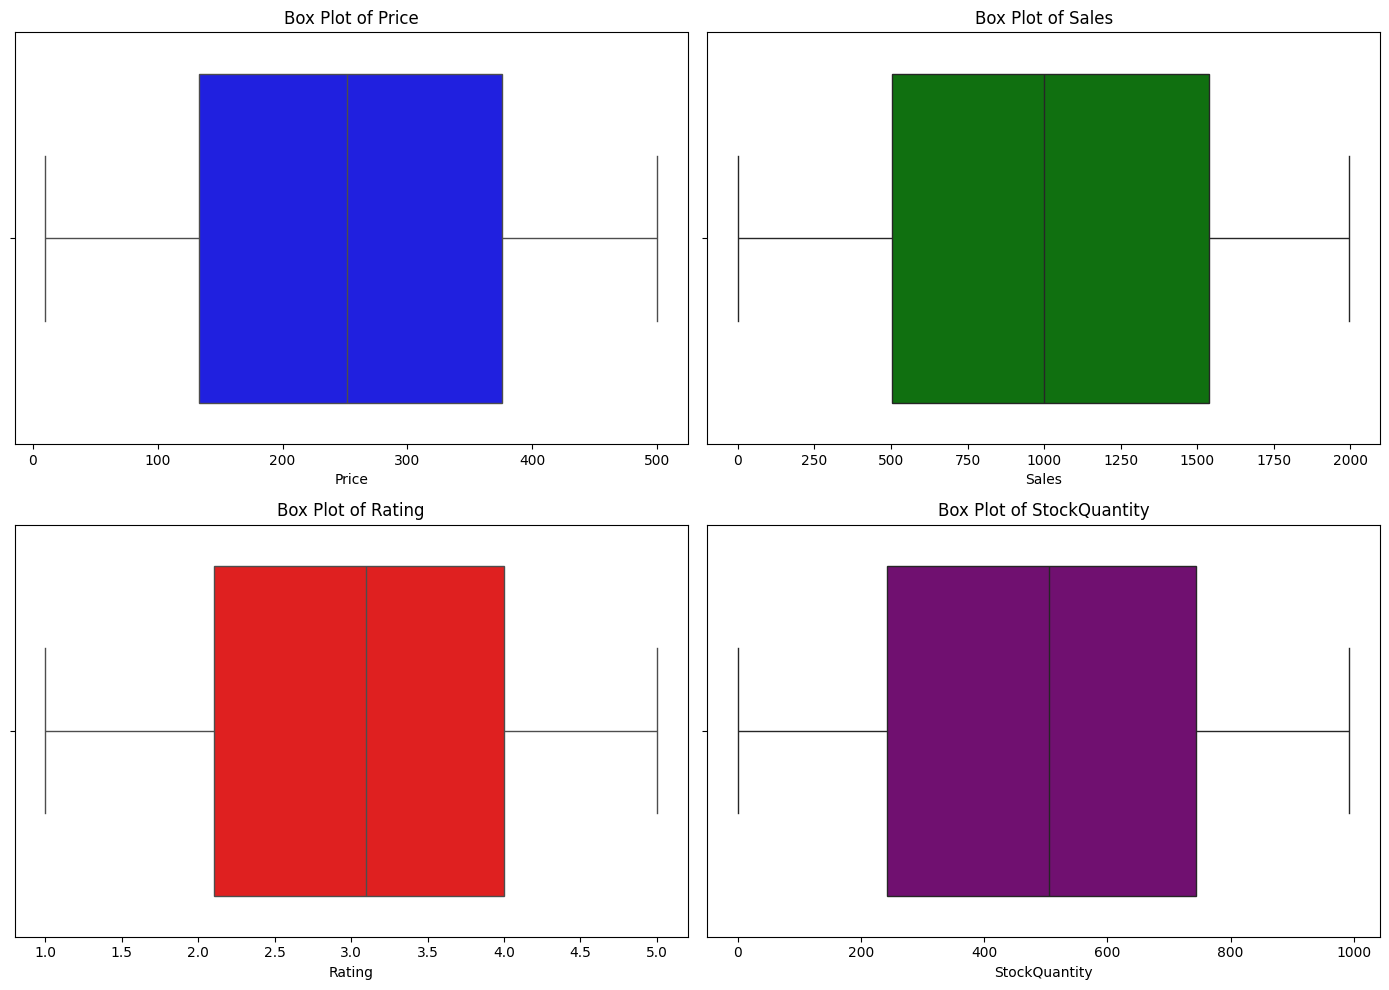

In [6]:
df_pd = df_cleaned.toPandas()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.boxplot(x=df_pd["Price"], ax=axes[0, 0], color="blue")
axes[0, 0].set_title("Box Plot of Price")
axes[0, 0].set_xlabel("Price")

sns.boxplot(x=df_pd["Sales"], ax=axes[0, 1], color="green")
axes[0, 1].set_title("Box Plot of Sales")
axes[0, 1].set_xlabel("Sales")

sns.boxplot(x=df_pd["Rating"], ax=axes[1, 0], color="red")
axes[1, 0].set_title("Box Plot of Rating")
axes[1, 0].set_xlabel("Rating")

sns.boxplot(x=df_pd["StockQuantity"], ax=axes[1, 1], color="purple")
axes[1, 1].set_title("Box Plot of StockQuantity")
axes[1, 1].set_xlabel("StockQuantity")

plt.tight_layout()
plt.show()


# Standarisasi Data

In [7]:
columns_to_standardize = ["Price", "Rating", "NumReviews", "StockQuantity", "Sales"]
assembler = VectorAssembler(inputCols=columns_to_standardize, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
pipeline = Pipeline(stages=[assembler, scaler])
scaled_df = pipeline.fit(df_cleaned).transform(df_cleaned)
scaled_df.select("ProductID", "scaled_features").show(5)

+---------+--------------------+
|ProductID|     scaled_features|
+---------+--------------------+
|        1|[2.83168254374402...|
|        2|[1.66253740565672...|
|        3|[2.95610932768222...|
|        4|[1.08015767386577...|
|        5|[2.79228184777162...|
+---------+--------------------+
only showing top 5 rows



# Visualization

In [8]:
df_cleaned.describe().show()

24/12/03 10:26:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-------------+--------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+---------+
|summary|         ProductID|  ProductName|            Category|             Price|            Rating|       NumReviews|     StockQuantity|           Discount|            Sales|     City|
+-------+------------------+-------------+--------------------+------------------+------------------+-----------------+------------------+-------------------+-----------------+---------+
|  count|              2000|         2000|                2000|              2000|              2000|             2000|              2000|               2000|             2000|     2000|
|   mean|             500.5|         NULL|                NULL|253.77551008415222| 3.025600005030632|         2498.753|           495.395|  0.251639999832958|         1011.037|     NULL|
| stddev|288.74718607933556|         NULL|                NULL|14

In [9]:
df_cleaned.show(10)

+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+
|ProductID|ProductName|   Category| Price|Rating|NumReviews|StockQuantity|Discount|Sales| DateAdded|       City|
+---------+-----------+-----------+------+------+----------+-------------+--------+-----+----------+-----------+
|        1| Headphones|Electronics|400.31|   1.7|      3772|           20|    0.08|  466|2023-11-10|Albuquerque|
|        2| Headphones|Electronics|235.03|   2.3|      2919|          663|    0.33| 1332|2023-09-28|     Queens|
|        3| Smartwatch|Electronics| 417.9|   1.8|      1184|          459|    0.31|  252|2023-10-20|     Austin|
|        4| Smartphone|Electronics| 152.7|   3.4|      2047|          475|    0.49| 1806|2023-12-05|     Dallas|
|        5|     Laptop|Electronics|394.74|   1.8|      1267|          831|    0.23| 1508|2023-08-10|     Tucson|
|        6| Headphones|Electronics| 93.56|   1.3|      2435|          600|    0.48|  241|2023-09